# Goal

The main idea is to apply the word-to-vector and Bert tokenizer to classify the reports when we do not have the label for each document. It mainly consists of three parts. Firstly, we clean the texts and embed them into the vector space. Secondly, we create a keyword list for each cluster and embed it into the vector space. Finally, we calculate the similarity scores between every list of text vectors and the keyword vectors, and assign each document to the closest cluster.

# Imports

In [4]:
import gensim
import gensim.downloader as gensim_api  ## for w2v
import json   ## for data 
import math
import matplotlib.pyplot as plt
import nltk  ## for processing
import numpy as np
import pandas as pd
import re
import seaborn as sns
from sklearn import metrics, manifold
import transformers  ## for bert

In [13]:
"""
File-level summary:
This file include the following class definition:
1. Data Preparation class, binds all preparation work on original dataset, including reading, 
    cleaning, and preprocessing; 
2. Clustering class, which create three target clusters of classification. 
3. One visualization of keywords. 
4. Embedding class, which is our feature engineering process. 
5. Three notes on embedding part.
6. Model class, include one class function, our algorithm design. 
7. One extra note on selection of similarity. 
"""

'\nFile-level summary:\nThis file include the following class definition:\n1. Data Preparation class, binds all preparation work on original dataset, including reading, \n    cleaning, and preprocessing; \n2. Clustering class, which create three target clusters of classification. \n3. One visualization of keywords. \n4. Embedding class, which is our feature engineering process. \n5. Three notes on embedding part.\n6. Model class, include one class function, our algorithm design. \n7. One extra note on selection of similarity. \n'

In [11]:
# Some global variables
NUM_OF_TOP_N = 20 
EMBEDDING_LENGTH = 20 
RESHAPE_DIM = 768
BATCH = round(1420/50)+1
BATCH_SIZE= 50  # each time we run for 50 documents. 

# Data Preparation

In [6]:
class DataPreparation:
    """This class binds all preparation work on data, including reading, cleaning, and preprocessing. 
    Include two major class functions ReadCSV for reading data and UtilsPreprocessText for processing. """
    
    def ReadCSV(self, file_name='real whole corpus.csv'):
        """
        this function is for reading data from csv file, cleaning a little, and return it. 
        Parameter: file_name end with .csv, default value is our real whole corpus.csv file
        Return: a dataframe named corpus
        """
        
        corpus = pd.read_csv(file_name, names = ['company', 'text'])

        for i in range(len(corpus)):
            if corpus.loc[i, 'text'] == ' ':
                corpus.loc[i, 'text'] = np.nan

        corpus = corpus.dropna()
        return corpus
    
    
    def UtilsPreprocessText(self, text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
        """
        Preprocess a string.
        Parameters:
            text: string - name of column containing text
            lst_stopwords: list - list of stopwords to remove
            flg_stemm: bool - whether stemming is to be applied
            flg_lemm: bool - whether lemmitisation is to be applied
        Return:
            cleaned text
        """
        ## clean (convert to lowercase and remove punctuations and characters and then strip)
        text = re.sub(r'[^\w\s]', '', str(text).lower().strip())

        ## Tokenize (convert from string to list)
        lst_text = text.split()

        ## remove Stopwords
        if lst_stopwords is not None:
            lst_text = [word for word in lst_text if word not in lst_stopwords]

        ## Stemming (remove -ing, -ly, ...)
        if flg_stemm == True:
            ps = nltk.stem.porter.PorterStemmer()
            lst_text = [ps.stem(word) for word in lst_text]

        ## Lemmatisation (convert the word into root word)
        if flg_lemm == True:
            lem = nltk.stem.wordnet.WordNetLemmatizer()
            lst_text = [lem.lemmatize(word) for word in lst_text]

        ## back to string from list
        text = " ".join(lst_text)
        
        return text
    

new_instance = DataPreparation()
corpus = new_instance.ReadCSV()
lst_stopwords = nltk.corpus.stopwords.words("english")
corpus["text_clean"] = corpus["text"].apply(lambda x: new_instance.UtilsPreprocessText(x, flg_stemm=False, 
                                                  flg_lemm=True,lst_stopwords=lst_stopwords))

# Create target clusters

In [ ]:
class Clustering:
    """This class defined target clusters. Include one class function GetSimilarWords which return a list of keywords for each input category."""
    
    ## a pretrained NLP model 
    nlp = gensim_api.load("glove-wiki-gigaword-300")
    
    ## Define the keyword list for each cluster
    general_words = ['climate','risk','carbon','emission','environment','social','governance','dioxide','sustainability',
                     'green','economy','energy','efficiency','clean','waste','recuperation','renewable','wind','hydro',
                     'solar','global','warming','hydrocarbon','methane','oil','coal','gas','greenhouse','recycling',
                     'composting','soil','water','air','pollution','natural','hazard']

    physical_words =  ['heat','wave','cold','floods','droughts','wildfires','storms','change','precipitation','pattern',
                       'sea','level','rise','coastal','hazard','fluvial']

    transition_words = ['paris','agreement','regulatory','kyoto','protocol','environmental','protection','agency'] 


    def GetSimilarWords(self, lst_words, top, nlp):
        """
        This function is used to create a list of keywords for each category. 
        Parameters: lst_words, top_n most similar words, nlp model. 
        Return: a list form of top n keywords for a given list of words. 
        """
        lst_out = lst_words
        for tupla in nlp.most_similar(lst_words, topn=top):
            lst_out.append(tupla[0])
        return list(set(lst_out))

    
cluster_instance = Clustering()
## create dictionary of this form: {category: [keywords]}
dic_clusters = {}
dic_clusters["GENERAL"] = cluster_instance.GetSimilarWords(cluster_instance.general_words, top=NUM_OF_TOP_N, nlp=cluster_instance.nlp)
dic_clusters["PHYSICAL"] = cluster_instance.GetSimilarWords(cluster_instance.physical_words, top=NUM_OF_TOP_N, nlp=cluster_instance.nlp)
dic_clusters["TRANSITION"] = cluster_instance.GetSimilarWords(cluster_instance.transition_words, top=NUM_OF_TOP_N, nlp=cluster_instance.nlp)

## print some
for k,v in dic_clusters.items():
    print(k, ": ", v[0:5], "...", len(v))

[==================================================] 100.0% 376.1/376.1MB downloaded


# Visualization

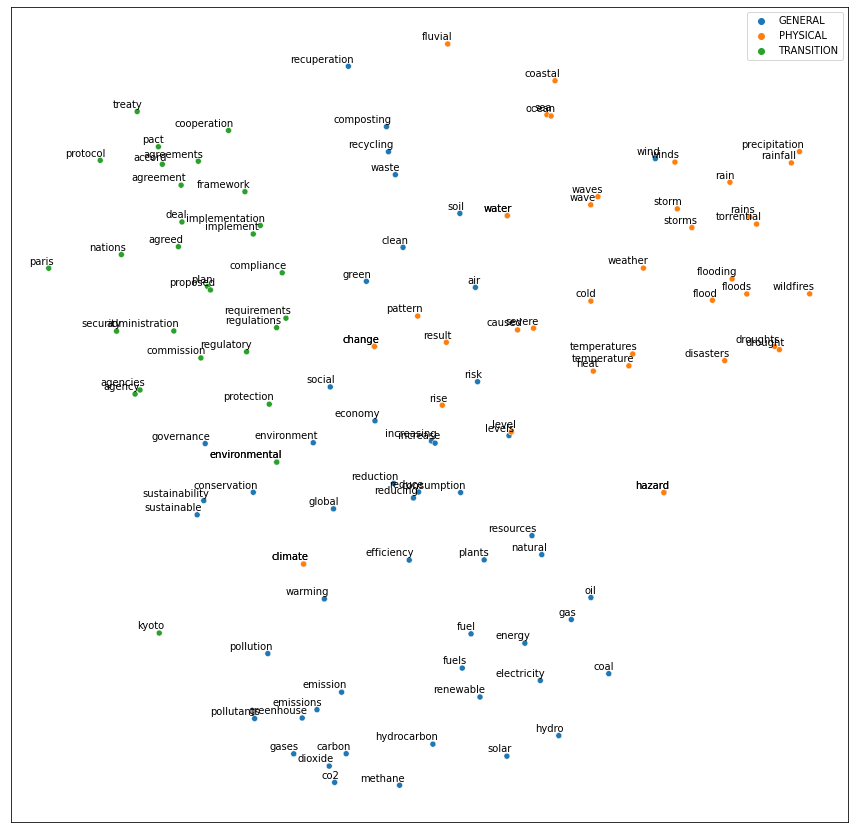

In [9]:
"""This part is to create a visualization of keywords by applying a dimensionality reduction 
algorithm (TSNE), and the more separated of each cluster, the better the result."""

nlp = cluster_instance.nlp

## word embedding
tot_words = [word for v in dic_clusters.values() for word in v]
X = nlp[tot_words]
        
## pca
pca = manifold.TSNE(perplexity=40, n_components=2, init='pca')
X = pca.fit_transform(X)

## create dtf
dtf = pd.DataFrame()
for k,v in dic_clusters.items():
    size = len(dtf) + len(v)
    dtf_group = pd.DataFrame(X[len(dtf):size], columns=["x","y"], index=v)
    dtf_group["cluster"] = k
    dtf = dtf.append(dtf_group)
        
## plot
fig,ax = plt.subplots()
fig.set_figheight(15)
fig.set_figwidth(15)
sns.scatterplot(data=dtf, x="x", y="y", hue="cluster", ax=ax)
ax.legend()
ax.set(xlabel=None, ylabel=None, xticks=[], xticklabels=[], yticks=[], yticklabels=[])
for i in range(len(dtf)):
    ax.annotate(dtf.index[i], xy=(dtf["x"].iloc[i], dtf["y"].iloc[i]), xytext=(5,2), textcoords='offset points',
                ha='right', va='bottom')

# Feature engineering

In [ ]:
class Embedding:
    """ This class defines feature engineering part, which in our case, is embedding the 
    corpus that has been preprocessed and the target clusters created in the same vector space."""
    
    tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
    nlp = transformers.TFBertModel.from_pretrained('bert-base-uncased')
    
    def UtilsBertEmbedding(self, txt, tokenizer, nlp):
        """
        Embedding function
        
        Parameters: txt, tokenizer, nlp model
        Return: embedding vector
        """
        idx = tokenizer.encode(txt)
        idx = np.array(idx)[None,:]  
        embedding = nlp(idx)
        X = np.array(embedding[0][0][1:-1])
        return X

    
# create embedding for each documents    
embedding_instance = Embedding()
lst_mean_vecs = []
for i in range(len(corpus)):
    words = corpus['text_clean'].iloc[i].split(' ')

    mean_vecs = []
    for j in range(math.floor(len(words)/EMBEDDING_LENGTH)):
        txt = ' '.join(words[(EMBEDDING_LENGTH*j):(EMBEDDING_LENGTH*(j+1))])
        mean_vecs.append(embedding_instance.UtilsBertEmbedding(txt, embedding_instance.tokenizer, 
                                                               embedding_instance.nlp).mean(0))
        print(i, j)
    
    np.save('document_' + str(i) + '.npy', mean_vecs)
    lst_mean_vecs.append(mean_vecs)
        
        
X = np.array(lst_mean_vecs, dtype=object)

In [ ]:
# create embedding for each cluster. 
dic_y = {k: embedding_instancce.UtilsBertEmbedding(v, embedding_instance.tokenizer, 
                                                   embedding_instance.nlp).mean(0) for k,v in dic_clusters.items()}


<h2>Note 1: Another way of embedding: sliding window method

In [ ]:
def utils_bert_embedding(txt, tokenizer, nlp):
    """This is another possible way of embedding. Since we did not use it to generate output at last, 
    this method is only included as an extra function. 
    
    Parameters: a piece of text, tokenizer, a nlp model 
    Return: embedding of input text. 
    """
    idx = tokenizer.encode(txt, stride = 10, return_overflowing_tokens=True, max_length = 500)[:-1]
                            # stride and max_length can be tuned. 
    idx = np.array(idx, dtype=np.int64)
    embedding = nlp(idx)

    X = np.array(embedding[0][0][1:-1])
    for i in range(1, len(embedding[0])):
        X = np.concatenate((X, np.array(embedding[0][i][1:-1])), axis=0)
    return X

## apply this embedding method to our corpus (skipped in our final output)
## create list of news vector
# lst_mean_vecs = [utils_bert_embedding(txt, tokenizer, nlp).mean(0) for txt in corpus["text_clean"]]
text_clean = corpus["text_clean"].reset_index(drop=True).copy()[0:50] #run for a small sample
lst_mean_vecs = []
for i in range(len(corpus["text_clean"])):
    txt = text_clean.iloc[i]
    try:
        item = utils_bert_embedding(txt, tokenizer, nlp).mean(0)
        lst_mean_vecs.append(item)
        print(i)
    except:
        lst_mean_vecs.append(np.zeros(item.shape))
        print('error',i)
        
        

<h2>Note 2: If re-run from embeddings directly

In [26]:
"""This block of code is for loading the saved local embeddings, shouldn't be necessary in most cases."""
# lst_mean_vecs = []
# for i in range(700, 750):
#     mean_vecs = np.load('document_' + str(i) + '.npy')   
#     if mean_vecs.size == 0:
#         print(i)
#     lst_mean_vecs.append(mean_vecs)
# X = np.array(lst_mean_vecs, dtype=object)

<h2>Note 3: If stick with our current embedding method (i.e., cut each document by a fixed length and do embedding), we
    could also change parameter--- the length to cut. 

In [7]:
"""This block of code is for change length of cut to 50, we ran only first 
50 documents for this part, output also included. 
"""

# lst_mean_vecs = []
# #for i in range(len(corpus)):
# for i in range(50):
#     words = corpus['text_clean'].iloc[i].split(' ')

#     mean_vecs = []
#     for j in range(math.floor(len(words)/50)):
#         txt = ' '.join(words[(50*j):(50*(j+1))])    
#         mean_vecs.append(utils_bert_embedding(txt, tokenizer, nlp).mean(0))
#         print(i, j)
    
#     np.save('document_' + str(i) + '(50).npy', mean_vecs)
#     lst_mean_vecs.append(mean_vecs)
        
# X = np.array(lst_mean_vecs, dtype=object)

# Model design

In [39]:
class Model:
    """
    This class defines the model algorithm"""
    
    def ModelDesign(self, X, dic_y):
        """
        This function defines the whole model, which uses cosine similarity calculation first, 
        and then classify each document according to the highest similarity score. 
        
        Parameters:
        X: embedding vector of each documents. 
        dic_y: embedding vector of keywords. 
        
        Return:
        ratio, a list stores ratio of each group. 
        """
        ratios = []
        ## compute cosine similarities
        for mean_vec in X:
            if len(mean_vec) == 0:
                continue

            similarities = np.array([metrics.pairwise.cosine_similarity(mean_vec, y.reshape(1,RESHAPE_DIM)).T.tolist()[0] 
                                     for y in dic_y.values()]).T

            ## adjust and rescale
            labels = list(dic_y.keys())

            for i in range(len(similarities)):        
                ### assign randomly if there is no similarity
                if sum(similarities[i]) == 0:
                    similarities[i] = [0]*len(labels)
                    similarities[i][np.random.choice(range(len(labels)))] = 1

                ### rescale so they sum = 1
                similarities[i] = similarities[i] / sum(similarities[i])

            ## classify the label with highest similarity score
            predicted_prob = similarities
            predicted = [labels[np.argmax(pred)] for pred in predicted_prob]

            ratios.append(np.array([predicted.count('GENERAL')/len(predicted), predicted.count('PHYSICAL')/len(predicted),
                                    predicted.count('TRANSITION')/len(predicted)]))
            
            return ratios
        
model = Model()
ratios = model.ModelDesign(X, dic_y)

<h2>Note 4: Selection of similarity calculations

In [ ]:
"""There are also some other similarity calculation methods, we used cosine similarity, 
a more general function included below."""

def similarity_classify(X, dic_y, method):
    """Similarity function:
    
    Parameters: 
    embedding of documents X,
    embedding of keywords dic_y, 
    method selected from cosine similarity, pairwise distance, euclidean distance. 
    
    Return: 
    Predicted probability with predicted class of each document. 
    """
    if method == 'cosine_similarity':
        similarities = np.array([metrics.pairwise.cosine_similarity(X, y.reshape(1,RESHAPE_DIM)).T.tolist()[0] for y in dic_y.values()]).T
    elif method == 'pairwise_distances':
        similarities = np.array([metrics.pairwise.pairwise_distances(X, y.reshape(1,RESHAPE_DIM)).T.tolist()[0] for y in dic_y.values()]).T
    elif method == 'euclidean_distances':
        similarities = np.array([metrics.pairwise.euclidean_distances(X, y.reshape(1,RESHAPE_DIM)).T.tolist()[0] for y in dic_y.values()]).T

    ## adjust and rescale
    labels = list(dic_y.keys())
    for i in range(len(similarities)):
        ### assign randomly if there is no similarity
        if sum(similarities[i]) == 0:
            similarities[i] = [0]*len(labels)
            similarities[i][np.random.choice(range(len(labels)))] = 1
        ### rescale so they sum = 1
        similarities[i] = similarities[i] / sum(similarities[i])

    ## classify the label with highest similarity score
    predicted_prob = similarities
    predicted = [labels[np.argmax(pred)] for pred in predicted_prob]
    return predicted_prob, predicted

<h2>Continue with our previous model...

In [40]:
pd.DataFrame(ratios).to_csv('ratios_1420.csv')

In [21]:
total_ratios = pd.DataFrame()
for i in range(1, BATCH):   
    ratios = pd.read_csv('Report_ratios/ratios_' + str(BATCH_SIZE*i) + '.csv', index_col = 0)
    total_ratios = pd.concat([total_ratios, ratios])
    
ratios = pd.read_csv('Report_ratios/ratios_1420.csv', index_col = 0)
total_ratios = pd.concat([total_ratios, ratios])

total_ratios.rename(columns = {'0':'General Risk', '1':'Physical Risk', '2':'Transition Risk'})

,General Risk,Physical Risk,Transition Risk
0,0.036952,0.161663,0.801386
1,0.037736,0.216981,0.745283
2,0.057971,0.463768,0.478261
3,0.061376,0.060964,0.877660
4,0.071429,0.214286,0.714286
...,...,...,...
15,0.025000,0.150000,0.825000
16,0.278378,0.041892,0.679730
17,0.000000,0.057143,0.942857
18,0.142857,0.102041,0.755102


In [25]:
labels = list(['GENERAL', 'PHYSICAL', 'TRANSITION'])
pred = [labels[np.argmax(total_ratios.iloc[i])] for i in range(len(total_ratios))]
np.array([pred.count('GENERAL')/len(pred), pred.count('PHYSICAL')/len(pred),
          pred.count('TRANSITION')/len(pred)])

array([0.05166313, 0.08280255, 0.86553432])